# Load dependent libraries

In [1]:
import pandas as pd
import glob
import ast
import seaborn as sns
import collections
import matplotlib.pyplot as plt

# Assign each signature extracted from 100 SomaticSiMu-generated mutational catalogs associated with Skin-Melanoma by SigProfilerExtractor as:

### 1. True Positive

### 2. False Positive

### 3. True Negative

### 4. False Negative

In [2]:
def signature_hit(signature_combo_path = "Skin-Melanoma_sbs_sigs.txt", extracted_signature_path="COSMIC_SBS96_Activities_refit.txt"):

    groundtruth = [line.strip("\n") for line in open(signature_combo_path)]
    groundtruth = [ast.literal_eval(x) for x in groundtruth]
    sigprofilerresults = pd.read_csv(extracted_signature_path, sep="\t")
    sigprofilerresults.drop(labels=["Samples"], axis=1, inplace=True)
    sigprofilerresults[sigprofilerresults != 0] = 1

    df = pd.DataFrame(index=range(100), 
                 columns=list(set([j for i in groundtruth for j in i])),
                     data=0)

    for seq in range(100):

        """
        If cell = 0: No signature simulated or extracted (true negative)
        If cell = 1: Signature simulated but not extracted (false negative)
        If cell = 2: Signature extracted but not simulated (false positive)
        If cell = 3: Signature simulated and extracted (true positive)

        """

        #Add 1 for each signature in groundtruth
        original = groundtruth[seq]

        for x in original:
            df.loc[seq, x] += 1

        #Add 2 for each signature extracted
        estimate = list(sigprofilerresults.loc[seq,][sigprofilerresults.loc[seq,] > 0].index)

        for y in estimate:
            df.loc[seq, y] += 2

    filtered_df = df.replace({0: "True Negative", 1: "False Negative", 2: "False Positive", 3: "True Positive"})
    return filtered_df
  

In [3]:
hits_df = signature_hit(signature_combo_path = "Skin-Melanoma_sbs_sigs.txt", extracted_signature_path="/Users/davidchen/Documents/GitHub/SomaticSiMu_Benchmark/Signature/SBS96/Suggested_Solution/COSMIC_SBS96_Decomposed_Solution/Activities/COSMIC_SBS96_Activities_refit.txt")
signature_hit(signature_combo_path = "Skin-Melanoma_sbs_sigs.txt", extracted_signature_path="/Users/davidchen/Documents/GitHub/SomaticSiMu_Benchmark/Signature/SBS96/Suggested_Solution/COSMIC_SBS96_Decomposed_Solution/Activities/COSMIC_SBS96_Activities_refit.txt")

,SBS7c,SBS5,SBS17a,SBS7d,SBS7b,SBS7a,SBS17b,SBS38,SBS58,SBS13,SBS40,SBS1,SBS2
0,False Negative,False Negative,True Negative,True Positive,True Positive,True Positive,True Negative,True Negative,True Negative,True Negative,True Negative,True Negative,True Negative
1,False Negative,True Positive,True Negative,False Negative,False Negative,True Positive,True Negative,True Negative,True Negative,True Negative,True Negative,True Positive,True Negative
2,True Negative,True Positive,True Negative,True Negative,False Positive,False Positive,True Negative,False Negative,True Negative,False Negative,False Negative,True Positive,False Negative
3,False Negative,False Negative,True Negative,True Positive,True Positive,True Positive,True Negative,True Negative,True Negative,True Negative,True Negative,False Negative,True Negative
4,False Negative,True Positive,True Negative,False Negative,False Negative,False Negative,True Negative,True Negative,True Negative,True Negative,False Positive,True Positive,True Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,True Positive,False Positive,True Negative,False Negative,True Positive,True Positive,True Negative,True Negative,True Negative,True Negative,True Negative,False Positive,True Negative
96,True Positive,True Positive,True Negative,False Negative,True Positive,True Positive,True Negative,True Negative,True Negative,True Negative,True Negative,True Positive,True Negative
97,False Negative,True Positive,True Negative,False Negative,False Negative,True Positive,True Negative,True Negative,True Negative,True Negative,True Negative,True Positive,True Negative
98,False Negative,False Negative,True Negative,True Positive,True Positive,True Positive,True Negative,True Negative,True Negative,True Negative,True Negative,True Negative,True Negative


# Calculate sensitivity and specificity metrics for each signature

In [6]:
def metrics_df(hits_df):
    metrics_df = pd.DataFrame(columns=hits_df.columns, index=['Sensitivity', 'Specificity'], data=0)
    signature_list = list(hits_df.columns)
    for sig in signature_list:
        value_count = hits_df[sig].value_counts()
        metrics_df.loc['Sensitivity', sig] = (hits_df[sig] == 'True Positive').sum() / ((hits_df[sig] == 'True Positive').sum() + (hits_df[sig] == 'False Negative').sum())
        metrics_df.loc['Specificity', sig] = (hits_df[sig] == 'True Negative').sum() / ((hits_df[sig] == 'True Negative').sum() + (hits_df[sig] == 'False Positive').sum())
    return metrics_df

In [7]:
metrics_df(hits_df)

,SBS7c,SBS5,SBS17a,SBS7d,SBS7b,SBS7a,SBS17b,SBS38,SBS58,SBS13,SBS40,SBS1,SBS2
Sensitivity,0.294872,0.648352,0,0.289157,0.710843,0.795181,0.000000,0.117647,0,0,0.125,0.619718,0
Specificity,0.818182,0.444444,1,0.470588,0.058824,0.058824,0.979592,0.939759,1,1,0.750,0.413793,1


# Plot each hit for each signature as a stacked bar graph

In [10]:
def metrics_plot(hits_df):

    labels = sorted(hits_df.columns)
    true_pos = [len(hits_df[hits_df[x] == "True Positive"]) for x in labels]
    true_neg = [len(hits_df[hits_df[x] == "True Negative"]) for x in labels]
    false_pos = [len(hits_df[hits_df[x] == "False Positive"]) for x in labels]
    false_neg = [len(hits_df[hits_df[x] == "False Negative"]) for x in labels]

    width = 0.5      

    fig, ax = plt.subplots(figsize=(20,10))

    ax.bar(labels, false_neg, width, edgecolor="black", label='False Negative', color="thistle")
    ax.bar(labels, true_neg, width, edgecolor="black", bottom = false_neg, label='True Negative', color="indigo")
    ax.bar(labels, false_pos, width, edgecolor="black", bottom = [x + y for x, y in zip(true_neg, false_neg)], label='False Positive', color="yellowgreen")
    true_false_neg_bottom = [x + y for x, y in zip(true_neg, false_neg)]
    ax.bar(labels, true_pos, width, edgecolor="black", bottom = [x + y for x, y in zip(true_false_neg_bottom, false_pos)], label='True Positive', color="darkolivegreen")
    ax.set_ylim(0,105)
    ax.set_xticklabels(labels, ha="right", rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.legend(bbox_to_anchor=(1.02, 1), prop={'size': 30})
    ax.set_xlabel("Simulated Mutational Signature", size=40, labelpad=20)
    ax.set_ylabel("Count of Each Hit", size=40, labelpad=20)
    plt.show()

/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_37062/828978229.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, ha="right", rotation=45)


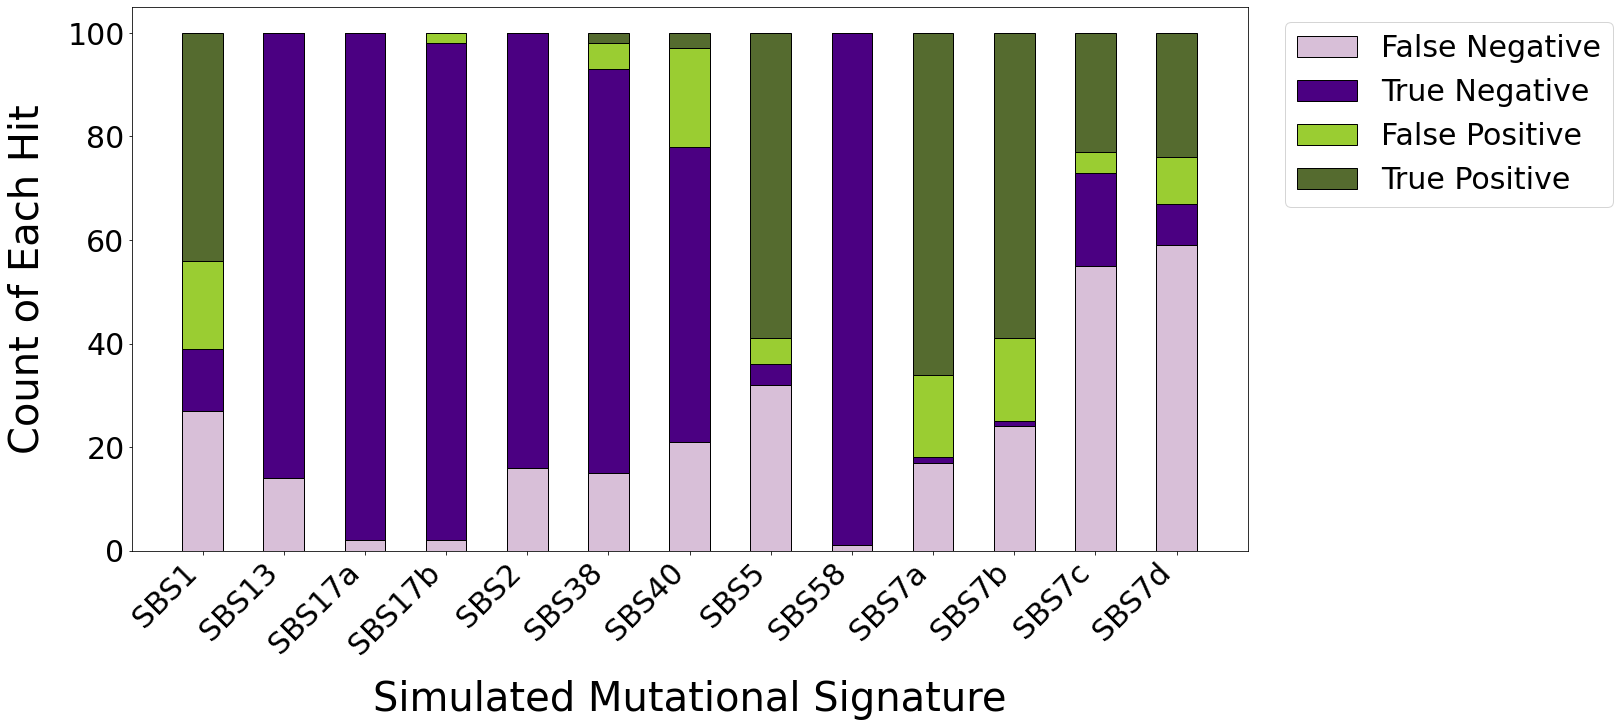

In [11]:
metrics_plot(hits_df)